# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [ ]:
# can comment out after executing
#!unzip processed_celeba_small.zip

In [1]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/0.4.0/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [2]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

In [3]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    transform = transforms.Compose([transforms.Resize(image_size),
                                    transforms.ToTensor()])
    
    dataset = datasets.ImageFolder(data_dir, transform)
    
    loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
    
    return loader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [4]:
# Define function hyperparameters
batch_size = 100
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should see square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

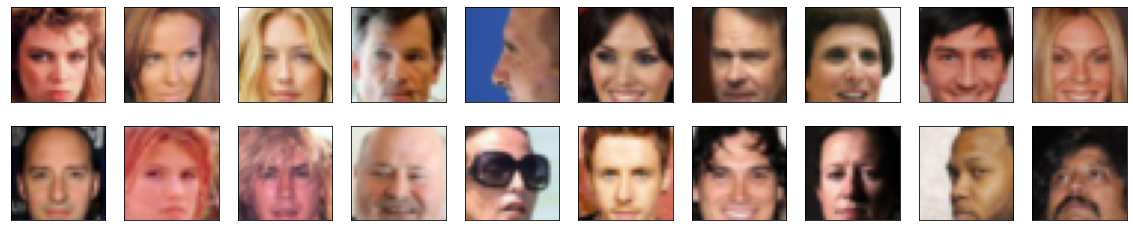

In [5]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size//2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [6]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = x * (max - min) + min
    return x


In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9922)
Max:  tensor(0.9686)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [8]:
import torch.nn as nn
import torch.nn.functional as F

In [9]:
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [10]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()
        
        self.conv_dim = conv_dim

        # complete init function
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        #self.conv4 = conv(conv_dim*4, conv_dim*8, 4)
        
        self.fc = nn.Linear(conv_dim*4*4*4, 1)
        
        self.relu = nn.ReLU()

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        #x = self.relu(self.conv4(x))
        
        x = x.view(-1, self.conv_dim*4*4*4)
        
        x = self.fc(x)
        
        return x


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [11]:
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    ## TODO: Complete this function
    ## create a sequence of transpose + optional batch norm layers
    layers = []
    tconv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    
    # append conv layer
    layers.append(tconv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
     
    # using Sequential container
    return nn.Sequential(*layers)

In [12]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)
        
        self.tconv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.tconv2 = deconv(conv_dim*2, conv_dim, 4)
        self.tconv3 = deconv(conv_dim, 3, 4, batch_norm=False)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        x = self.fc(x)
        x = x.view(-1, self.conv_dim*4, 4, 4)
        
        x = self.relu(self.tconv1(x))
        x = self.relu(self.tconv2(x))
        
        x = self.tanh(self.tconv3(x))
        
        return x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [13]:
from torch.nn import init

def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1: 
            init.normal_(m.weight.data, 1.0, 0.02)
            init.constant_(m.bias.data, 0.0)

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [15]:
# Define model hyperparams
d_conv_dim = 64
g_conv_dim = 64
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=4096, out_features=1, bias=True)
  (relu): ReLU()
)

Generator(
  (relu): ReLU()
  (tanh): Tanh()
  (fc): Linear(in_features=100, out_features=4096, bias=True)
  (tconv1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (tconv2): Sequential(
    (0): ConvTranspose2d(128, 64, 

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [17]:
def real_loss(D_out, loss_function='BCE'):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    labels = torch.ones(batch_size)
    
    if train_on_gpu:
        labels = labels.cuda()
        
    if loss_function == 'BCE':
        criterion = nn.BCEWithLogitsLoss()
        loss = criterion(D_out.squeeze(), labels)
    
    if loss_function == 'LSE':
        loss = torch.mean((D_out-1)**2)
    
    return loss

def fake_loss(D_out, loss_function='BCE'):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    
    if train_on_gpu:
        labels = labels.cuda()
    
    if loss_function == 'BCE':
        criterion = nn.BCEWithLogitsLoss()
        loss = criterion(D_out.squeeze(), labels)
    
    if loss_function == 'LSE':
        loss = torch.mean(D_out**2)
    
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [18]:
import torch.optim as optim

# Create optimizers for the discriminator D and generator G

lr = 0.0002
beta1 = 0.5
beta2 = 0.999 # default value

d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [21]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)
            
            if train_on_gpu:
                real_images = real_images.cuda()

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            d_optimizer.zero_grad()
            
            D_real = D(real_images)
            d_real_loss = real_loss(D_real)
            
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
            
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()
            
            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            
            if train_on_gpu:
                z = z.cuda()
            
            fake_images = G(z)

            D_fake = D(fake_images)
            g_loss = real_loss(D_fake) 

            g_loss.backward()
            g_optimizer.step()
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        with torch.no_grad():
            samples_z = G(fixed_z)
            samples_z = samples_z.detach().cpu()
            samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples64.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

#### This run is 50 epochs with an initial depth of 64.

In [51]:
# set number of epochs 
n_epochs = 50


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   50] | d_loss: 1.5362 | g_loss: 1.7131
Epoch [    1/   50] | d_loss: 0.0793 | g_loss: 6.0213
Epoch [    1/   50] | d_loss: 0.2218 | g_loss: 3.8497
Epoch [    1/   50] | d_loss: 0.4499 | g_loss: 3.6951
Epoch [    1/   50] | d_loss: 0.7951 | g_loss: 4.4200
Epoch [    1/   50] | d_loss: 0.4722 | g_loss: 1.8980
Epoch [    1/   50] | d_loss: 0.9400 | g_loss: 1.1750
Epoch [    1/   50] | d_loss: 0.3565 | g_loss: 4.2674
Epoch [    1/   50] | d_loss: 0.3643 | g_loss: 3.7230
Epoch [    1/   50] | d_loss: 0.5637 | g_loss: 2.9458
Epoch [    1/   50] | d_loss: 0.6697 | g_loss: 3.1911
Epoch [    1/   50] | d_loss: 0.7307 | g_loss: 3.3303
Epoch [    1/   50] | d_loss: 0.8825 | g_loss: 1.3584
Epoch [    1/   50] | d_loss: 0.4459 | g_loss: 1.9348
Epoch [    1/   50] | d_loss: 0.5934 | g_loss: 2.3466
Epoch [    1/   50] | d_loss: 0.7158 | g_loss: 1.4882
Epoch [    1/   50] | d_loss: 0.8807 | g_loss: 2.5251
Epoch [    1/   50] | d_loss: 0.5066 | g_loss: 2.5571
Epoch [    2/   50] | d_loss

Epoch [    9/   50] | d_loss: 0.4670 | g_loss: 1.9209
Epoch [    9/   50] | d_loss: 0.9050 | g_loss: 1.0544
Epoch [    9/   50] | d_loss: 0.4450 | g_loss: 2.4509
Epoch [    9/   50] | d_loss: 1.9386 | g_loss: 5.5202
Epoch [    9/   50] | d_loss: 0.4748 | g_loss: 1.9621
Epoch [    9/   50] | d_loss: 0.6777 | g_loss: 1.4510
Epoch [    9/   50] | d_loss: 0.7176 | g_loss: 1.1175
Epoch [    9/   50] | d_loss: 0.7847 | g_loss: 1.5912
Epoch [    9/   50] | d_loss: 0.4697 | g_loss: 2.2432
Epoch [    9/   50] | d_loss: 0.4325 | g_loss: 2.4097
Epoch [   10/   50] | d_loss: 0.5856 | g_loss: 1.4151
Epoch [   10/   50] | d_loss: 0.4924 | g_loss: 2.5784
Epoch [   10/   50] | d_loss: 0.3860 | g_loss: 3.0832
Epoch [   10/   50] | d_loss: 0.4707 | g_loss: 1.5118
Epoch [   10/   50] | d_loss: 0.5892 | g_loss: 1.9977
Epoch [   10/   50] | d_loss: 0.5961 | g_loss: 3.1756
Epoch [   10/   50] | d_loss: 0.6194 | g_loss: 2.9613
Epoch [   10/   50] | d_loss: 0.4692 | g_loss: 1.3105
Epoch [   10/   50] | d_loss

Epoch [   17/   50] | d_loss: 0.2808 | g_loss: 2.1677
Epoch [   17/   50] | d_loss: 0.3962 | g_loss: 3.8211
Epoch [   18/   50] | d_loss: 0.6444 | g_loss: 4.3291
Epoch [   18/   50] | d_loss: 0.2857 | g_loss: 1.8852
Epoch [   18/   50] | d_loss: 0.1392 | g_loss: 1.9962
Epoch [   18/   50] | d_loss: 0.6044 | g_loss: 2.2432
Epoch [   18/   50] | d_loss: 0.2815 | g_loss: 2.8490
Epoch [   18/   50] | d_loss: 0.2134 | g_loss: 2.4588
Epoch [   18/   50] | d_loss: 0.2601 | g_loss: 3.8005
Epoch [   18/   50] | d_loss: 0.1831 | g_loss: 3.2526
Epoch [   18/   50] | d_loss: 0.1918 | g_loss: 3.3775
Epoch [   18/   50] | d_loss: 0.1789 | g_loss: 3.6821
Epoch [   18/   50] | d_loss: 0.2213 | g_loss: 2.3327
Epoch [   18/   50] | d_loss: 0.1958 | g_loss: 3.5551
Epoch [   18/   50] | d_loss: 2.2809 | g_loss: 0.0013
Epoch [   18/   50] | d_loss: 0.3519 | g_loss: 3.3820
Epoch [   18/   50] | d_loss: 0.3989 | g_loss: 3.3156
Epoch [   18/   50] | d_loss: 0.3686 | g_loss: 3.2456
Epoch [   18/   50] | d_loss

Epoch [   26/   50] | d_loss: 0.1202 | g_loss: 3.6750
Epoch [   26/   50] | d_loss: 0.1222 | g_loss: 4.2305
Epoch [   26/   50] | d_loss: 0.1401 | g_loss: 3.1641
Epoch [   26/   50] | d_loss: 0.5465 | g_loss: 3.4644
Epoch [   26/   50] | d_loss: 0.1587 | g_loss: 3.9298
Epoch [   26/   50] | d_loss: 0.2413 | g_loss: 1.9961
Epoch [   26/   50] | d_loss: 0.1988 | g_loss: 3.9332
Epoch [   26/   50] | d_loss: 0.3225 | g_loss: 2.1770
Epoch [   26/   50] | d_loss: 0.2040 | g_loss: 5.1979
Epoch [   26/   50] | d_loss: 0.3284 | g_loss: 5.4805
Epoch [   26/   50] | d_loss: 0.2559 | g_loss: 4.0354
Epoch [   26/   50] | d_loss: 0.1632 | g_loss: 3.5579
Epoch [   27/   50] | d_loss: 0.3322 | g_loss: 4.1143
Epoch [   27/   50] | d_loss: 0.1976 | g_loss: 2.8787
Epoch [   27/   50] | d_loss: 0.2725 | g_loss: 2.2112
Epoch [   27/   50] | d_loss: 0.1248 | g_loss: 3.9236
Epoch [   27/   50] | d_loss: 0.1621 | g_loss: 3.1869
Epoch [   27/   50] | d_loss: 0.1204 | g_loss: 3.9522
Epoch [   27/   50] | d_loss

Epoch [   34/   50] | d_loss: 0.2079 | g_loss: 4.3075
Epoch [   34/   50] | d_loss: 0.2398 | g_loss: 3.9832
Epoch [   34/   50] | d_loss: 0.2028 | g_loss: 4.9713
Epoch [   34/   50] | d_loss: 0.1263 | g_loss: 4.1386
Epoch [   35/   50] | d_loss: 0.2082 | g_loss: 5.3043
Epoch [   35/   50] | d_loss: 0.1512 | g_loss: 3.6569
Epoch [   35/   50] | d_loss: 0.1217 | g_loss: 5.0006
Epoch [   35/   50] | d_loss: 0.1662 | g_loss: 4.7925
Epoch [   35/   50] | d_loss: 0.1170 | g_loss: 4.1230
Epoch [   35/   50] | d_loss: 0.6275 | g_loss: 2.3721
Epoch [   35/   50] | d_loss: 0.1178 | g_loss: 4.1172
Epoch [   35/   50] | d_loss: 0.0811 | g_loss: 2.6307
Epoch [   35/   50] | d_loss: 0.4661 | g_loss: 1.9351
Epoch [   35/   50] | d_loss: 0.0590 | g_loss: 3.6583
Epoch [   35/   50] | d_loss: 0.0942 | g_loss: 5.1701
Epoch [   35/   50] | d_loss: 2.1122 | g_loss: 0.0659
Epoch [   35/   50] | d_loss: 0.2554 | g_loss: 3.4118
Epoch [   35/   50] | d_loss: 0.1755 | g_loss: 4.8647
Epoch [   35/   50] | d_loss

Epoch [   43/   50] | d_loss: 0.0985 | g_loss: 4.3709
Epoch [   43/   50] | d_loss: 0.1732 | g_loss: 3.5370
Epoch [   43/   50] | d_loss: 1.1408 | g_loss: 2.5469
Epoch [   43/   50] | d_loss: 0.0843 | g_loss: 4.8624
Epoch [   43/   50] | d_loss: 0.1232 | g_loss: 5.2479
Epoch [   43/   50] | d_loss: 0.1014 | g_loss: 4.4275
Epoch [   43/   50] | d_loss: 0.0742 | g_loss: 4.3250
Epoch [   43/   50] | d_loss: 0.1253 | g_loss: 3.8419
Epoch [   43/   50] | d_loss: 0.2792 | g_loss: 4.2844
Epoch [   43/   50] | d_loss: 0.2151 | g_loss: 3.8587
Epoch [   43/   50] | d_loss: 0.1920 | g_loss: 3.7116
Epoch [   43/   50] | d_loss: 0.0348 | g_loss: 5.6984
Epoch [   43/   50] | d_loss: 0.0594 | g_loss: 4.1796
Epoch [   43/   50] | d_loss: 0.1573 | g_loss: 3.8255
Epoch [   44/   50] | d_loss: 0.2650 | g_loss: 5.3809
Epoch [   44/   50] | d_loss: 0.0579 | g_loss: 5.6491
Epoch [   44/   50] | d_loss: 0.0747 | g_loss: 4.8744
Epoch [   44/   50] | d_loss: 0.0618 | g_loss: 4.5281
Epoch [   44/   50] | d_loss

#### This run is 100 epochs with an initial depth of 32.

In [20]:
# set number of epochs 
n_epochs = 100


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/  100] | d_loss: 1.4884 | g_loss: 0.9809
Epoch [    1/  100] | d_loss: 0.2102 | g_loss: 3.8909
Epoch [    1/  100] | d_loss: 0.6094 | g_loss: 4.2101
Epoch [    1/  100] | d_loss: 0.3309 | g_loss: 3.9818
Epoch [    1/  100] | d_loss: 0.4607 | g_loss: 3.4469
Epoch [    1/  100] | d_loss: 0.7542 | g_loss: 6.3125
Epoch [    1/  100] | d_loss: 0.7470 | g_loss: 2.0777
Epoch [    1/  100] | d_loss: 0.5104 | g_loss: 2.1592
Epoch [    1/  100] | d_loss: 0.7874 | g_loss: 3.7881
Epoch [    1/  100] | d_loss: 0.5450 | g_loss: 2.5520
Epoch [    1/  100] | d_loss: 0.7350 | g_loss: 3.1803
Epoch [    1/  100] | d_loss: 0.6561 | g_loss: 1.8662
Epoch [    1/  100] | d_loss: 0.6455 | g_loss: 2.1485
Epoch [    1/  100] | d_loss: 0.7778 | g_loss: 2.3036
Epoch [    1/  100] | d_loss: 0.7982 | g_loss: 1.2792
Epoch [    1/  100] | d_loss: 0.7731 | g_loss: 2.5657
Epoch [    1/  100] | d_loss: 0.9955 | g_loss: 2.8386
Epoch [    1/  100] | d_loss: 0.9926 | g_loss: 1.0733
Epoch [    2/  100] | d_loss

Epoch [    9/  100] | d_loss: 0.8420 | g_loss: 1.5691
Epoch [    9/  100] | d_loss: 0.5218 | g_loss: 2.3087
Epoch [    9/  100] | d_loss: 0.6840 | g_loss: 1.7784
Epoch [    9/  100] | d_loss: 0.4958 | g_loss: 1.6110
Epoch [    9/  100] | d_loss: 0.4685 | g_loss: 1.6812
Epoch [    9/  100] | d_loss: 1.0489 | g_loss: 1.9591
Epoch [    9/  100] | d_loss: 0.5118 | g_loss: 1.8939
Epoch [    9/  100] | d_loss: 0.4823 | g_loss: 1.5798
Epoch [    9/  100] | d_loss: 0.5817 | g_loss: 2.0947
Epoch [    9/  100] | d_loss: 0.6543 | g_loss: 2.2768
Epoch [   10/  100] | d_loss: 0.8754 | g_loss: 2.6280
Epoch [   10/  100] | d_loss: 0.6048 | g_loss: 1.7259
Epoch [   10/  100] | d_loss: 0.7094 | g_loss: 0.9442
Epoch [   10/  100] | d_loss: 0.5151 | g_loss: 0.6409
Epoch [   10/  100] | d_loss: 0.5465 | g_loss: 1.8604
Epoch [   10/  100] | d_loss: 1.0270 | g_loss: 0.8302
Epoch [   10/  100] | d_loss: 0.6030 | g_loss: 1.7971
Epoch [   10/  100] | d_loss: 0.6773 | g_loss: 1.9802
Epoch [   10/  100] | d_loss

Epoch [   17/  100] | d_loss: 0.2577 | g_loss: 2.9493
Epoch [   17/  100] | d_loss: 0.4008 | g_loss: 1.7212
Epoch [   18/  100] | d_loss: 0.3107 | g_loss: 3.4487
Epoch [   18/  100] | d_loss: 0.4195 | g_loss: 2.1057
Epoch [   18/  100] | d_loss: 0.3569 | g_loss: 3.2850
Epoch [   18/  100] | d_loss: 0.3389 | g_loss: 3.2178
Epoch [   18/  100] | d_loss: 0.3473 | g_loss: 3.0269
Epoch [   18/  100] | d_loss: 3.5067 | g_loss: 0.5767
Epoch [   18/  100] | d_loss: 0.3236 | g_loss: 2.9975
Epoch [   18/  100] | d_loss: 0.6592 | g_loss: 2.0606
Epoch [   18/  100] | d_loss: 0.2992 | g_loss: 3.0442
Epoch [   18/  100] | d_loss: 0.2881 | g_loss: 2.4714
Epoch [   18/  100] | d_loss: 0.9952 | g_loss: 0.8434
Epoch [   18/  100] | d_loss: 0.5238 | g_loss: 3.0998
Epoch [   18/  100] | d_loss: 0.2794 | g_loss: 2.6464
Epoch [   18/  100] | d_loss: 0.3835 | g_loss: 3.0909
Epoch [   18/  100] | d_loss: 0.2795 | g_loss: 1.9230
Epoch [   18/  100] | d_loss: 0.3901 | g_loss: 2.1632
Epoch [   18/  100] | d_loss

Epoch [   26/  100] | d_loss: 0.3442 | g_loss: 3.5363
Epoch [   26/  100] | d_loss: 0.3089 | g_loss: 3.5874
Epoch [   26/  100] | d_loss: 0.3905 | g_loss: 1.2819
Epoch [   26/  100] | d_loss: 0.5462 | g_loss: 4.0356
Epoch [   26/  100] | d_loss: 0.3834 | g_loss: 3.0128
Epoch [   26/  100] | d_loss: 0.5618 | g_loss: 2.1039
Epoch [   26/  100] | d_loss: 0.2190 | g_loss: 3.3741
Epoch [   26/  100] | d_loss: 0.3004 | g_loss: 1.9857
Epoch [   26/  100] | d_loss: 0.5603 | g_loss: 3.7506
Epoch [   26/  100] | d_loss: 0.3575 | g_loss: 2.1861
Epoch [   26/  100] | d_loss: 0.7175 | g_loss: 3.0470
Epoch [   26/  100] | d_loss: 0.2706 | g_loss: 3.4594
Epoch [   27/  100] | d_loss: 0.3371 | g_loss: 2.6226
Epoch [   27/  100] | d_loss: 0.3219 | g_loss: 2.8550
Epoch [   27/  100] | d_loss: 0.3692 | g_loss: 2.7009
Epoch [   27/  100] | d_loss: 0.2532 | g_loss: 2.8176
Epoch [   27/  100] | d_loss: 0.2664 | g_loss: 3.1034
Epoch [   27/  100] | d_loss: 0.3704 | g_loss: 3.3415
Epoch [   27/  100] | d_loss

Epoch [   34/  100] | d_loss: 0.2967 | g_loss: 3.9583
Epoch [   34/  100] | d_loss: 0.1531 | g_loss: 3.8005
Epoch [   34/  100] | d_loss: 0.2362 | g_loss: 3.5265
Epoch [   34/  100] | d_loss: 2.7170 | g_loss: 7.4711
Epoch [   35/  100] | d_loss: 0.6033 | g_loss: 4.0216
Epoch [   35/  100] | d_loss: 0.3079 | g_loss: 3.4955
Epoch [   35/  100] | d_loss: 0.1340 | g_loss: 3.4345
Epoch [   35/  100] | d_loss: 0.2986 | g_loss: 4.6621
Epoch [   35/  100] | d_loss: 0.2888 | g_loss: 2.4908
Epoch [   35/  100] | d_loss: 0.3253 | g_loss: 3.3342
Epoch [   35/  100] | d_loss: 0.2313 | g_loss: 4.2504
Epoch [   35/  100] | d_loss: 0.0900 | g_loss: 4.5750
Epoch [   35/  100] | d_loss: 0.1884 | g_loss: 2.2134
Epoch [   35/  100] | d_loss: 0.2570 | g_loss: 3.4919
Epoch [   35/  100] | d_loss: 0.3201 | g_loss: 2.2199
Epoch [   35/  100] | d_loss: 0.4696 | g_loss: 2.6341
Epoch [   35/  100] | d_loss: 0.2585 | g_loss: 2.7628
Epoch [   35/  100] | d_loss: 0.3018 | g_loss: 2.7205
Epoch [   35/  100] | d_loss

Epoch [   43/  100] | d_loss: 0.2837 | g_loss: 2.2078
Epoch [   43/  100] | d_loss: 0.2363 | g_loss: 4.6044
Epoch [   43/  100] | d_loss: 0.1737 | g_loss: 3.0589
Epoch [   43/  100] | d_loss: 0.1546 | g_loss: 3.4943
Epoch [   43/  100] | d_loss: 1.1052 | g_loss: 4.0654
Epoch [   43/  100] | d_loss: 0.2217 | g_loss: 3.2936
Epoch [   43/  100] | d_loss: 0.2793 | g_loss: 4.3020
Epoch [   43/  100] | d_loss: 0.2021 | g_loss: 3.9432
Epoch [   43/  100] | d_loss: 0.1634 | g_loss: 4.3530
Epoch [   43/  100] | d_loss: 0.3547 | g_loss: 5.3317
Epoch [   43/  100] | d_loss: 0.1573 | g_loss: 3.3756
Epoch [   43/  100] | d_loss: 0.3361 | g_loss: 3.2813
Epoch [   43/  100] | d_loss: 0.2949 | g_loss: 2.8522
Epoch [   43/  100] | d_loss: 0.2267 | g_loss: 3.2589
Epoch [   44/  100] | d_loss: 0.3060 | g_loss: 2.3369
Epoch [   44/  100] | d_loss: 0.1603 | g_loss: 3.7239
Epoch [   44/  100] | d_loss: 0.1874 | g_loss: 3.9136
Epoch [   44/  100] | d_loss: 0.2767 | g_loss: 4.0259
Epoch [   44/  100] | d_loss

Epoch [   51/  100] | d_loss: 0.2840 | g_loss: 3.0250
Epoch [   51/  100] | d_loss: 0.0775 | g_loss: 3.8689
Epoch [   51/  100] | d_loss: 0.1997 | g_loss: 4.8837
Epoch [   51/  100] | d_loss: 0.3269 | g_loss: 4.5547
Epoch [   51/  100] | d_loss: 0.2114 | g_loss: 4.5471
Epoch [   51/  100] | d_loss: 0.0491 | g_loss: 4.2071
Epoch [   52/  100] | d_loss: 0.2042 | g_loss: 2.4562
Epoch [   52/  100] | d_loss: 0.5009 | g_loss: 3.3047
Epoch [   52/  100] | d_loss: 0.4224 | g_loss: 3.0331
Epoch [   52/  100] | d_loss: 0.0960 | g_loss: 5.0599
Epoch [   52/  100] | d_loss: 0.1793 | g_loss: 3.5874
Epoch [   52/  100] | d_loss: 0.1917 | g_loss: 3.6350
Epoch [   52/  100] | d_loss: 0.0834 | g_loss: 4.1107
Epoch [   52/  100] | d_loss: 0.0724 | g_loss: 5.2159
Epoch [   52/  100] | d_loss: 0.2150 | g_loss: 5.3189
Epoch [   52/  100] | d_loss: 0.3052 | g_loss: 2.5717
Epoch [   52/  100] | d_loss: 0.0860 | g_loss: 4.7060
Epoch [   52/  100] | d_loss: 0.2690 | g_loss: 3.5084
Epoch [   52/  100] | d_loss

Epoch [   60/  100] | d_loss: 0.1670 | g_loss: 3.3089
Epoch [   60/  100] | d_loss: 0.6230 | g_loss: 3.4515
Epoch [   60/  100] | d_loss: 0.2601 | g_loss: 3.7452
Epoch [   60/  100] | d_loss: 0.1589 | g_loss: 3.8654
Epoch [   60/  100] | d_loss: 0.1746 | g_loss: 4.5198
Epoch [   60/  100] | d_loss: 0.1361 | g_loss: 3.7436
Epoch [   60/  100] | d_loss: 0.1152 | g_loss: 5.4059
Epoch [   60/  100] | d_loss: 0.1887 | g_loss: 3.4605
Epoch [   60/  100] | d_loss: 0.1516 | g_loss: 4.8353
Epoch [   60/  100] | d_loss: 2.4952 | g_loss: 8.6099
Epoch [   60/  100] | d_loss: 0.0494 | g_loss: 5.7733
Epoch [   60/  100] | d_loss: 0.2145 | g_loss: 3.7787
Epoch [   60/  100] | d_loss: 0.2428 | g_loss: 5.2737
Epoch [   60/  100] | d_loss: 0.2945 | g_loss: 3.9803
Epoch [   60/  100] | d_loss: 0.1247 | g_loss: 4.8626
Epoch [   60/  100] | d_loss: 0.4291 | g_loss: 2.4541
Epoch [   61/  100] | d_loss: 0.1688 | g_loss: 4.2106
Epoch [   61/  100] | d_loss: 0.2004 | g_loss: 4.9313
Epoch [   61/  100] | d_loss

Epoch [   68/  100] | d_loss: 0.2003 | g_loss: 3.1409
Epoch [   68/  100] | d_loss: 0.2337 | g_loss: 6.4722
Epoch [   68/  100] | d_loss: 0.0897 | g_loss: 6.4797
Epoch [   68/  100] | d_loss: 0.0656 | g_loss: 2.5132
Epoch [   68/  100] | d_loss: 0.0912 | g_loss: 4.2201
Epoch [   68/  100] | d_loss: 0.1153 | g_loss: 5.0657
Epoch [   68/  100] | d_loss: 0.1657 | g_loss: 3.7103
Epoch [   68/  100] | d_loss: 0.1173 | g_loss: 4.5238
Epoch [   69/  100] | d_loss: 0.1906 | g_loss: 3.5724
Epoch [   69/  100] | d_loss: 0.3846 | g_loss: 6.8078
Epoch [   69/  100] | d_loss: 0.0970 | g_loss: 4.7305
Epoch [   69/  100] | d_loss: 0.6789 | g_loss: 5.6957
Epoch [   69/  100] | d_loss: 0.0957 | g_loss: 3.5930
Epoch [   69/  100] | d_loss: 0.6085 | g_loss: 1.8949
Epoch [   69/  100] | d_loss: 0.2301 | g_loss: 4.5901
Epoch [   69/  100] | d_loss: 0.0842 | g_loss: 5.1804
Epoch [   69/  100] | d_loss: 0.1020 | g_loss: 4.0585
Epoch [   69/  100] | d_loss: 0.0851 | g_loss: 5.8600
Epoch [   69/  100] | d_loss

Epoch [   77/  100] | d_loss: 0.2839 | g_loss: 4.5861
Epoch [   77/  100] | d_loss: 0.2950 | g_loss: 3.9209
Epoch [   77/  100] | d_loss: 0.0831 | g_loss: 4.0779
Epoch [   77/  100] | d_loss: 0.1356 | g_loss: 3.9926
Epoch [   77/  100] | d_loss: 0.1054 | g_loss: 4.5159
Epoch [   77/  100] | d_loss: 0.0757 | g_loss: 5.0359
Epoch [   77/  100] | d_loss: 0.1831 | g_loss: 5.1863
Epoch [   77/  100] | d_loss: 0.2052 | g_loss: 6.3740
Epoch [   77/  100] | d_loss: 0.1035 | g_loss: 5.3148
Epoch [   77/  100] | d_loss: 0.3165 | g_loss: 4.8575
Epoch [   77/  100] | d_loss: 0.0837 | g_loss: 5.0230
Epoch [   77/  100] | d_loss: 0.0483 | g_loss: 6.3728
Epoch [   77/  100] | d_loss: 0.1814 | g_loss: 4.6552
Epoch [   77/  100] | d_loss: 0.1597 | g_loss: 4.8316
Epoch [   77/  100] | d_loss: 0.2126 | g_loss: 6.9149
Epoch [   77/  100] | d_loss: 0.0978 | g_loss: 5.2443
Epoch [   77/  100] | d_loss: 0.0988 | g_loss: 4.3654
Epoch [   77/  100] | d_loss: 0.0936 | g_loss: 6.4213
Epoch [   78/  100] | d_loss

Epoch [   85/  100] | d_loss: 0.2228 | g_loss: 3.7525
Epoch [   85/  100] | d_loss: 0.1544 | g_loss: 4.4415
Epoch [   85/  100] | d_loss: 0.1231 | g_loss: 4.5248
Epoch [   85/  100] | d_loss: 0.2197 | g_loss: 5.0880
Epoch [   85/  100] | d_loss: 0.0554 | g_loss: 5.5433
Epoch [   85/  100] | d_loss: 0.0759 | g_loss: 5.5992
Epoch [   85/  100] | d_loss: 0.1966 | g_loss: 4.1231
Epoch [   85/  100] | d_loss: 0.1144 | g_loss: 4.6678
Epoch [   85/  100] | d_loss: 0.0757 | g_loss: 5.7207
Epoch [   85/  100] | d_loss: 0.1334 | g_loss: 3.5833
Epoch [   86/  100] | d_loss: 0.1679 | g_loss: 5.9093
Epoch [   86/  100] | d_loss: 0.1125 | g_loss: 6.6358
Epoch [   86/  100] | d_loss: 0.0501 | g_loss: 5.4091
Epoch [   86/  100] | d_loss: 0.0624 | g_loss: 5.3262
Epoch [   86/  100] | d_loss: 0.0335 | g_loss: 6.7050
Epoch [   86/  100] | d_loss: 0.0954 | g_loss: 5.7507
Epoch [   86/  100] | d_loss: 0.0934 | g_loss: 5.3187
Epoch [   86/  100] | d_loss: 0.0942 | g_loss: 8.6441
Epoch [   86/  100] | d_loss

Epoch [   93/  100] | d_loss: 0.1189 | g_loss: 4.1869
Epoch [   93/  100] | d_loss: 0.0632 | g_loss: 7.5486
Epoch [   94/  100] | d_loss: 0.0813 | g_loss: 6.1482
Epoch [   94/  100] | d_loss: 0.0982 | g_loss: 5.3172
Epoch [   94/  100] | d_loss: 0.1415 | g_loss: 7.7314
Epoch [   94/  100] | d_loss: 0.0552 | g_loss: 6.1228
Epoch [   94/  100] | d_loss: 0.1711 | g_loss: 5.2082
Epoch [   94/  100] | d_loss: 0.6037 | g_loss: 10.2459
Epoch [   94/  100] | d_loss: 0.0586 | g_loss: 6.0364
Epoch [   94/  100] | d_loss: 0.3015 | g_loss: 3.8821
Epoch [   94/  100] | d_loss: 0.0296 | g_loss: 5.7350
Epoch [   94/  100] | d_loss: 0.1279 | g_loss: 4.0839
Epoch [   94/  100] | d_loss: 0.0698 | g_loss: 6.6926
Epoch [   94/  100] | d_loss: 0.1745 | g_loss: 7.5254
Epoch [   94/  100] | d_loss: 0.0799 | g_loss: 4.8677
Epoch [   94/  100] | d_loss: 0.0969 | g_loss: 4.0407
Epoch [   94/  100] | d_loss: 0.1732 | g_loss: 5.9803
Epoch [   94/  100] | d_loss: 0.0194 | g_loss: 6.6002
Epoch [   94/  100] | d_los

#### This is 100 epochs with an initial depth of 64.

In [22]:
# set number of epochs 
n_epochs = 100


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/  100] | d_loss: 0.1279 | g_loss: 5.0566
Epoch [    1/  100] | d_loss: 0.3778 | g_loss: 6.6269
Epoch [    1/  100] | d_loss: 0.1617 | g_loss: 4.9089
Epoch [    1/  100] | d_loss: 0.7038 | g_loss: 5.6125
Epoch [    1/  100] | d_loss: 0.3169 | g_loss: 3.1122
Epoch [    1/  100] | d_loss: 0.9156 | g_loss: 5.3796
Epoch [    1/  100] | d_loss: 0.8860 | g_loss: 5.8143
Epoch [    1/  100] | d_loss: 0.5522 | g_loss: 3.7146
Epoch [    1/  100] | d_loss: 0.5135 | g_loss: 3.8027
Epoch [    1/  100] | d_loss: 0.6596 | g_loss: 3.3299
Epoch [    1/  100] | d_loss: 0.5727 | g_loss: 2.8793
Epoch [    1/  100] | d_loss: 1.0933 | g_loss: 5.4677
Epoch [    1/  100] | d_loss: 0.8515 | g_loss: 4.0690
Epoch [    1/  100] | d_loss: 0.5507 | g_loss: 2.5897
Epoch [    1/  100] | d_loss: 0.6452 | g_loss: 2.3144
Epoch [    1/  100] | d_loss: 0.7533 | g_loss: 1.8424
Epoch [    1/  100] | d_loss: 1.2649 | g_loss: 0.9104
Epoch [    1/  100] | d_loss: 0.4557 | g_loss: 2.7418
Epoch [    2/  100] | d_loss

Epoch [    9/  100] | d_loss: 0.9555 | g_loss: 0.7715
Epoch [    9/  100] | d_loss: 0.4762 | g_loss: 1.3906
Epoch [    9/  100] | d_loss: 0.4576 | g_loss: 1.6827
Epoch [    9/  100] | d_loss: 0.5369 | g_loss: 1.6275
Epoch [    9/  100] | d_loss: 0.6873 | g_loss: 2.6930
Epoch [    9/  100] | d_loss: 0.4047 | g_loss: 1.4483
Epoch [    9/  100] | d_loss: 0.6923 | g_loss: 3.5744
Epoch [    9/  100] | d_loss: 0.5841 | g_loss: 1.4050
Epoch [    9/  100] | d_loss: 0.2920 | g_loss: 2.9206
Epoch [    9/  100] | d_loss: 0.3793 | g_loss: 3.2931
Epoch [   10/  100] | d_loss: 0.5783 | g_loss: 1.2944
Epoch [   10/  100] | d_loss: 0.6456 | g_loss: 2.0475
Epoch [   10/  100] | d_loss: 0.5242 | g_loss: 1.6530
Epoch [   10/  100] | d_loss: 1.3700 | g_loss: 0.4947
Epoch [   10/  100] | d_loss: 0.5344 | g_loss: 2.2956
Epoch [   10/  100] | d_loss: 0.4741 | g_loss: 2.0448
Epoch [   10/  100] | d_loss: 0.3728 | g_loss: 3.1958
Epoch [   10/  100] | d_loss: 0.4679 | g_loss: 3.0139
Epoch [   10/  100] | d_loss

Epoch [   17/  100] | d_loss: 0.3446 | g_loss: 2.7099
Epoch [   17/  100] | d_loss: 0.1918 | g_loss: 3.4494
Epoch [   18/  100] | d_loss: 0.1510 | g_loss: 2.9491
Epoch [   18/  100] | d_loss: 0.1837 | g_loss: 3.2315
Epoch [   18/  100] | d_loss: 0.1328 | g_loss: 3.1479
Epoch [   18/  100] | d_loss: 0.1995 | g_loss: 2.8420
Epoch [   18/  100] | d_loss: 0.1277 | g_loss: 2.9877
Epoch [   18/  100] | d_loss: 0.5590 | g_loss: 4.6886
Epoch [   18/  100] | d_loss: 0.2390 | g_loss: 3.2674
Epoch [   18/  100] | d_loss: 0.7049 | g_loss: 1.7658
Epoch [   18/  100] | d_loss: 0.4553 | g_loss: 2.2619
Epoch [   18/  100] | d_loss: 0.1694 | g_loss: 4.7835
Epoch [   18/  100] | d_loss: 0.3369 | g_loss: 1.9599
Epoch [   18/  100] | d_loss: 0.2247 | g_loss: 3.4574
Epoch [   18/  100] | d_loss: 0.2381 | g_loss: 3.8739
Epoch [   18/  100] | d_loss: 0.3233 | g_loss: 3.9473
Epoch [   18/  100] | d_loss: 0.1542 | g_loss: 3.5412
Epoch [   18/  100] | d_loss: 0.4488 | g_loss: 4.9089
Epoch [   18/  100] | d_loss

Epoch [   26/  100] | d_loss: 0.0702 | g_loss: 4.6967
Epoch [   26/  100] | d_loss: 0.1354 | g_loss: 4.2458
Epoch [   26/  100] | d_loss: 0.1696 | g_loss: 4.6220
Epoch [   26/  100] | d_loss: 0.5434 | g_loss: 5.2557
Epoch [   26/  100] | d_loss: 0.1427 | g_loss: 3.7193
Epoch [   26/  100] | d_loss: 0.1057 | g_loss: 3.9881
Epoch [   26/  100] | d_loss: 0.1652 | g_loss: 3.4982
Epoch [   26/  100] | d_loss: 0.1013 | g_loss: 5.1788
Epoch [   26/  100] | d_loss: 0.0940 | g_loss: 4.8138
Epoch [   26/  100] | d_loss: 0.3657 | g_loss: 3.0345
Epoch [   26/  100] | d_loss: 0.3341 | g_loss: 2.6552
Epoch [   26/  100] | d_loss: 0.1970 | g_loss: 4.4189
Epoch [   27/  100] | d_loss: 0.2287 | g_loss: 4.8519
Epoch [   27/  100] | d_loss: 0.1432 | g_loss: 3.7430
Epoch [   27/  100] | d_loss: 0.1639 | g_loss: 2.8371
Epoch [   27/  100] | d_loss: 0.1578 | g_loss: 5.1921
Epoch [   27/  100] | d_loss: 0.1239 | g_loss: 3.8210
Epoch [   27/  100] | d_loss: 0.0916 | g_loss: 4.7294
Epoch [   27/  100] | d_loss

Epoch [   34/  100] | d_loss: 0.0929 | g_loss: 4.2071
Epoch [   34/  100] | d_loss: 0.1343 | g_loss: 4.4495
Epoch [   34/  100] | d_loss: 0.1211 | g_loss: 4.8310
Epoch [   34/  100] | d_loss: 0.0927 | g_loss: 4.7804
Epoch [   35/  100] | d_loss: 0.1406 | g_loss: 3.8769
Epoch [   35/  100] | d_loss: 0.1282 | g_loss: 4.5025
Epoch [   35/  100] | d_loss: 0.0452 | g_loss: 5.3734
Epoch [   35/  100] | d_loss: 0.1022 | g_loss: 4.1948
Epoch [   35/  100] | d_loss: 0.0377 | g_loss: 6.3357
Epoch [   35/  100] | d_loss: 0.1940 | g_loss: 4.1145
Epoch [   35/  100] | d_loss: 0.1042 | g_loss: 2.7597
Epoch [   35/  100] | d_loss: 0.0568 | g_loss: 4.9443
Epoch [   35/  100] | d_loss: 1.5350 | g_loss: 0.5340
Epoch [   35/  100] | d_loss: 0.2410 | g_loss: 3.9153
Epoch [   35/  100] | d_loss: 0.1273 | g_loss: 3.7210
Epoch [   35/  100] | d_loss: 0.1297 | g_loss: 4.3146
Epoch [   35/  100] | d_loss: 0.0994 | g_loss: 4.8645
Epoch [   35/  100] | d_loss: 0.2403 | g_loss: 4.7894
Epoch [   35/  100] | d_loss

Epoch [   43/  100] | d_loss: 0.0773 | g_loss: 6.0925
Epoch [   43/  100] | d_loss: 0.0299 | g_loss: 5.6345
Epoch [   43/  100] | d_loss: 0.0464 | g_loss: 6.1655
Epoch [   43/  100] | d_loss: 0.0474 | g_loss: 5.4328
Epoch [   43/  100] | d_loss: 0.0558 | g_loss: 4.7954
Epoch [   43/  100] | d_loss: 0.1161 | g_loss: 3.9233
Epoch [   43/  100] | d_loss: 0.0971 | g_loss: 4.2384
Epoch [   43/  100] | d_loss: 0.1810 | g_loss: 3.2731
Epoch [   43/  100] | d_loss: 0.0729 | g_loss: 3.9780
Epoch [   43/  100] | d_loss: 0.0863 | g_loss: 4.9087
Epoch [   43/  100] | d_loss: 0.0428 | g_loss: 4.9895
Epoch [   43/  100] | d_loss: 0.5123 | g_loss: 0.4380
Epoch [   43/  100] | d_loss: 0.3750 | g_loss: 3.9919
Epoch [   43/  100] | d_loss: 0.5908 | g_loss: 2.9799
Epoch [   44/  100] | d_loss: 0.2716 | g_loss: 4.4076
Epoch [   44/  100] | d_loss: 0.0749 | g_loss: 5.1229
Epoch [   44/  100] | d_loss: 0.1122 | g_loss: 5.2349
Epoch [   44/  100] | d_loss: 0.0612 | g_loss: 4.4142
Epoch [   44/  100] | d_loss

Epoch [   51/  100] | d_loss: 0.1948 | g_loss: 5.9056
Epoch [   51/  100] | d_loss: 0.0527 | g_loss: 5.0116
Epoch [   51/  100] | d_loss: 0.1496 | g_loss: 5.2897
Epoch [   51/  100] | d_loss: 0.0567 | g_loss: 4.5784
Epoch [   51/  100] | d_loss: 0.1146 | g_loss: 3.8006
Epoch [   51/  100] | d_loss: 0.0307 | g_loss: 6.1741
Epoch [   52/  100] | d_loss: 0.0320 | g_loss: 6.1537
Epoch [   52/  100] | d_loss: 0.0197 | g_loss: 5.9813
Epoch [   52/  100] | d_loss: 0.0699 | g_loss: 5.6314
Epoch [   52/  100] | d_loss: 5.8380 | g_loss: 0.5465
Epoch [   52/  100] | d_loss: 0.1271 | g_loss: 4.8668
Epoch [   52/  100] | d_loss: 0.0390 | g_loss: 4.3041
Epoch [   52/  100] | d_loss: 0.0824 | g_loss: 6.2879
Epoch [   52/  100] | d_loss: 0.0666 | g_loss: 4.9849
Epoch [   52/  100] | d_loss: 0.0365 | g_loss: 4.4924
Epoch [   52/  100] | d_loss: 0.1669 | g_loss: 4.6192
Epoch [   52/  100] | d_loss: 0.0891 | g_loss: 4.0871
Epoch [   52/  100] | d_loss: 0.0163 | g_loss: 6.6955
Epoch [   52/  100] | d_loss

Epoch [   60/  100] | d_loss: 0.0481 | g_loss: 4.9920
Epoch [   60/  100] | d_loss: 0.0838 | g_loss: 4.5619
Epoch [   60/  100] | d_loss: 0.0975 | g_loss: 4.8413
Epoch [   60/  100] | d_loss: 0.0340 | g_loss: 6.2971
Epoch [   60/  100] | d_loss: 0.0512 | g_loss: 6.0777
Epoch [   60/  100] | d_loss: 0.0381 | g_loss: 5.8913
Epoch [   60/  100] | d_loss: 0.0772 | g_loss: 6.2370
Epoch [   60/  100] | d_loss: 0.0581 | g_loss: 6.0439
Epoch [   60/  100] | d_loss: 0.0338 | g_loss: 7.5648
Epoch [   60/  100] | d_loss: 0.0616 | g_loss: 7.7759
Epoch [   60/  100] | d_loss: 0.0180 | g_loss: 6.2159
Epoch [   60/  100] | d_loss: 0.0234 | g_loss: 7.6083
Epoch [   60/  100] | d_loss: 0.0089 | g_loss: 5.5710
Epoch [   60/  100] | d_loss: 0.1326 | g_loss: 5.3804
Epoch [   60/  100] | d_loss: 0.0357 | g_loss: 5.8665
Epoch [   60/  100] | d_loss: 0.1912 | g_loss: 7.2110
Epoch [   61/  100] | d_loss: 0.0806 | g_loss: 5.3884
Epoch [   61/  100] | d_loss: 0.0584 | g_loss: 6.9585
Epoch [   61/  100] | d_loss

Epoch [   68/  100] | d_loss: 0.0344 | g_loss: 10.5456
Epoch [   68/  100] | d_loss: 0.0202 | g_loss: 8.5120
Epoch [   68/  100] | d_loss: 0.0076 | g_loss: 7.4994
Epoch [   68/  100] | d_loss: 0.0317 | g_loss: 8.7299
Epoch [   68/  100] | d_loss: 0.0136 | g_loss: 7.5117
Epoch [   68/  100] | d_loss: 0.0129 | g_loss: 7.9248
Epoch [   68/  100] | d_loss: 0.0047 | g_loss: 9.9906
Epoch [   68/  100] | d_loss: 0.0094 | g_loss: 8.7748
Epoch [   69/  100] | d_loss: 0.8750 | g_loss: 18.9696
Epoch [   69/  100] | d_loss: 0.0265 | g_loss: 7.4132
Epoch [   69/  100] | d_loss: 0.0224 | g_loss: 8.0851
Epoch [   69/  100] | d_loss: 0.0196 | g_loss: 7.1409
Epoch [   69/  100] | d_loss: 0.2288 | g_loss: 10.3952
Epoch [   69/  100] | d_loss: 0.0374 | g_loss: 6.9096
Epoch [   69/  100] | d_loss: 0.0155 | g_loss: 6.4438
Epoch [   69/  100] | d_loss: 0.0109 | g_loss: 6.6573
Epoch [   69/  100] | d_loss: 0.0126 | g_loss: 7.0439
Epoch [   69/  100] | d_loss: 0.0219 | g_loss: 6.1701
Epoch [   69/  100] | d_l

Epoch [   77/  100] | d_loss: 0.1363 | g_loss: 8.7639
Epoch [   77/  100] | d_loss: 0.0096 | g_loss: 10.2423
Epoch [   77/  100] | d_loss: 0.0108 | g_loss: 6.2450
Epoch [   77/  100] | d_loss: 0.0411 | g_loss: 7.7793
Epoch [   77/  100] | d_loss: 0.0872 | g_loss: 11.7471
Epoch [   77/  100] | d_loss: 0.0305 | g_loss: 7.4873
Epoch [   77/  100] | d_loss: 0.0086 | g_loss: 7.1972
Epoch [   77/  100] | d_loss: 0.0055 | g_loss: 9.6702
Epoch [   77/  100] | d_loss: 0.0089 | g_loss: 7.1110
Epoch [   77/  100] | d_loss: 0.0486 | g_loss: 5.8644
Epoch [   77/  100] | d_loss: 0.1432 | g_loss: 8.2416
Epoch [   77/  100] | d_loss: 0.4394 | g_loss: 16.4068
Epoch [   77/  100] | d_loss: 0.0181 | g_loss: 5.8585
Epoch [   77/  100] | d_loss: 0.0115 | g_loss: 8.0293
Epoch [   77/  100] | d_loss: 0.0223 | g_loss: 6.8387
Epoch [   77/  100] | d_loss: 0.1400 | g_loss: 3.8741
Epoch [   77/  100] | d_loss: 0.0156 | g_loss: 6.2301
Epoch [   77/  100] | d_loss: 0.0126 | g_loss: 6.9070
Epoch [   78/  100] | d_l

Epoch [   85/  100] | d_loss: 0.0259 | g_loss: 7.4798
Epoch [   85/  100] | d_loss: 0.0091 | g_loss: 6.7719
Epoch [   85/  100] | d_loss: 0.0155 | g_loss: 6.0369
Epoch [   85/  100] | d_loss: 0.2418 | g_loss: 5.1589
Epoch [   85/  100] | d_loss: 0.0321 | g_loss: 5.7615
Epoch [   85/  100] | d_loss: 0.0908 | g_loss: 5.5469
Epoch [   85/  100] | d_loss: 0.0327 | g_loss: 8.1773
Epoch [   85/  100] | d_loss: 0.0373 | g_loss: 7.5897
Epoch [   85/  100] | d_loss: 0.0227 | g_loss: 7.5978
Epoch [   85/  100] | d_loss: 0.0469 | g_loss: 7.5232
Epoch [   86/  100] | d_loss: 0.0030 | g_loss: 9.7180
Epoch [   86/  100] | d_loss: 0.0288 | g_loss: 7.5238
Epoch [   86/  100] | d_loss: 0.0343 | g_loss: 8.3397
Epoch [   86/  100] | d_loss: 0.0192 | g_loss: 7.9520
Epoch [   86/  100] | d_loss: 0.0089 | g_loss: 9.6223
Epoch [   86/  100] | d_loss: 0.0144 | g_loss: 7.4084
Epoch [   86/  100] | d_loss: 0.0346 | g_loss: 6.2316
Epoch [   86/  100] | d_loss: 0.0078 | g_loss: 8.0754
Epoch [   86/  100] | d_loss

Epoch [   93/  100] | d_loss: 0.0739 | g_loss: 6.7789
Epoch [   93/  100] | d_loss: 0.0277 | g_loss: 7.2853
Epoch [   94/  100] | d_loss: 0.0501 | g_loss: 6.7168
Epoch [   94/  100] | d_loss: 0.0489 | g_loss: 7.2307
Epoch [   94/  100] | d_loss: 0.0086 | g_loss: 7.4792
Epoch [   94/  100] | d_loss: 0.0570 | g_loss: 7.4473
Epoch [   94/  100] | d_loss: 0.0209 | g_loss: 7.4600
Epoch [   94/  100] | d_loss: 0.0336 | g_loss: 7.4640
Epoch [   94/  100] | d_loss: 0.0038 | g_loss: 10.4658
Epoch [   94/  100] | d_loss: 0.0063 | g_loss: 10.5972
Epoch [   94/  100] | d_loss: 0.0144 | g_loss: 8.8524
Epoch [   94/  100] | d_loss: 0.0518 | g_loss: 6.5261
Epoch [   94/  100] | d_loss: 0.0895 | g_loss: 6.6252
Epoch [   94/  100] | d_loss: 0.0442 | g_loss: 5.6392
Epoch [   94/  100] | d_loss: 0.0056 | g_loss: 10.1255
Epoch [   94/  100] | d_loss: 0.0268 | g_loss: 5.1625
Epoch [   94/  100] | d_loss: 0.0237 | g_loss: 7.7689
Epoch [   94/  100] | d_loss: 0.7792 | g_loss: 18.4807
Epoch [   94/  100] | d_

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

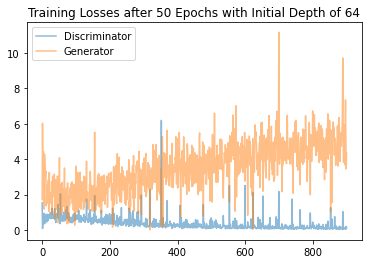

In [58]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses after 50 Epochs with Initial Depth of 64")
plt.legend()
plt.show()

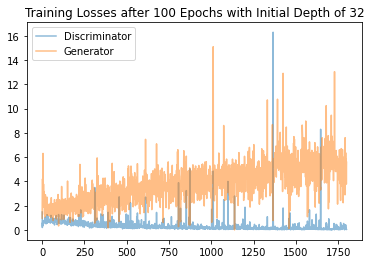

In [21]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses after 100 Epochs with Initial Depth of 32")
plt.legend()
plt.show()

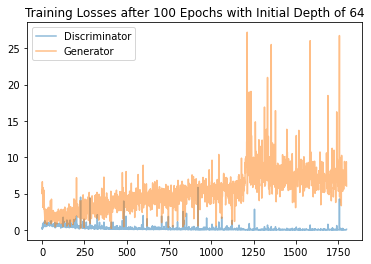

In [23]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses after 100 Epochs with Initial Depth of 64")
plt.legend()
plt.show()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [24]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [54]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

Samples generated with 50 epochs on a network with initial depth of 64.


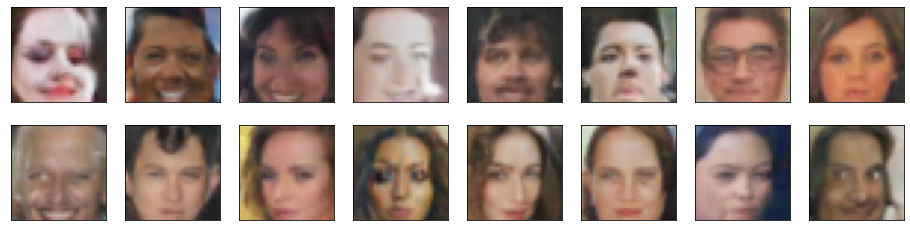

In [56]:
print('Samples generated with 50 epochs on a network with initial depth of 64.')
_ = view_samples(-1, samples)

In [23]:
# Load samples from generator, taken while training
with open('train_samples32.pkl', 'rb') as f:
    samples = pkl.load(f)

Samples generated with 100 epochs on a network with initial depth of 32.


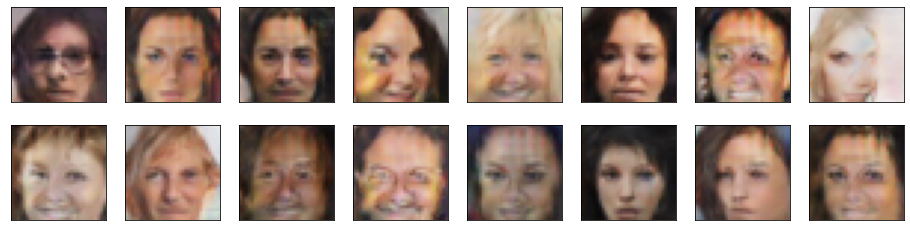

In [24]:
print('Samples generated with 100 epochs on a network with initial depth of 32.')
_ = view_samples(-1, samples)

In [25]:
# Load samples from generator, taken while training
with open('train_samples64.pkl', 'rb') as f:
    samples = pkl.load(f)

Samples generated with 100 epochs on a network with initial depth of 64.


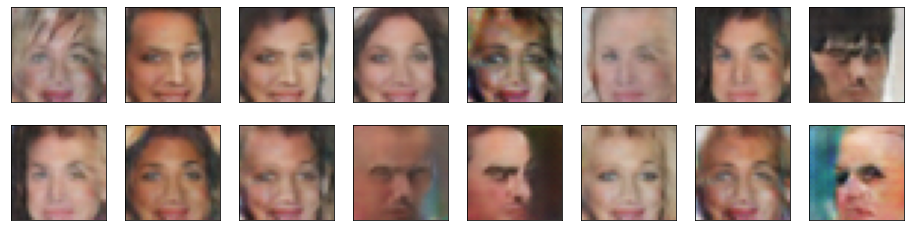

In [26]:
print('Samples generated with 100 epochs on a network with initial depth of 64.')
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** 

There needs to be more exploration into how the hyperparameters are affecting the final outcome. As can be seen above, the run with the best looking faces was actually the initial 50-epoch training with a depth of 64. Further training of the model (each training session was on a restarted kernel, thus being 'unique') did not yield better results. In fact, something appears to be going wrong, such that the final run of 100 epochs is trying to generate the same female face, and similar male faces. Overtraining this model is a concern, as it is getting almost "too good" at taking any given z input and mapping it to a single kind of face. 

Thus, it may be better to train for fewer epochs, and to explore how changing the hyperparameters around affects the final results. That would take many hours, however. I already have nearly 18 hours of training on this project completed. 

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.